# Advancing Mathematics by Guiding Human Intuition with AI — Knot Theory Path

**Focus:** Reconstructing the discovery path in knot theory from Davies et al., *Nature* (2021)  
**Scope:** We follow how ML-guided exploration suggested a relationship between Vassiliev invariants and the knot signature, and how this informed a conjecture and proof. We **skip** the later part on predicting exponents.

**Big Question:** How can AI surface latent mathematical structure that humans can then formalize and prove?

## Learning Objectives

By the end of this notebook you should be able to:
- Explain what a **knot invariant** is and why such invariants are central to knot classification.

- Reproduce, on a small dataset, the **AI-to-conjecture workflow**: from data collection $\rightarrow$ simple models $\rightarrow$ saliency/feature insights $\rightarrow$ human-guided conjecture.
- Articulate the difference between **pattern discovery** and **proof**, and why the latter still requires mathematical reasoning.

In **[Advancing mathematics by guiding human intuition with AI](https://www.nature.com/articles/s41586-021-04086-x)** (Davies et al., 2021), deep learning (DL) is used to discover mathematical conjectures. The authors propose the following framework. The process involves mathematicians iteratively

*  formulating hypotheses about data,
*  testing these hypotheses with deep learning (DL) models,
*   and then refining their hypotheses based on the results.

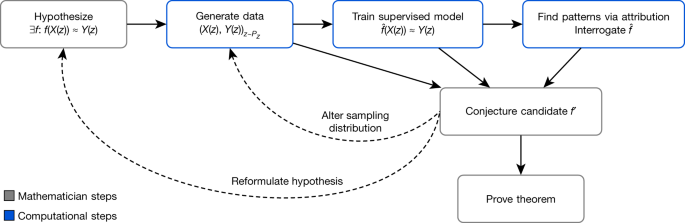

This methodology has led to the discovery of two original mathematical results:

1.  **Knot Theory**: Davies et al., “The signature and cusp geometry of hyperbolic knots.” (2021) [arXiv:2111.15323 ](https://arxiv.org/abs/2111.15323)
2.  **Representation Theory**:  Blundell, Charles D. et al. “Towards combinatorial invariance for Kazhdan-Lusztig polynomials.” [Representation Theory of the American Mathematical Society (2021)](https://www.ams.org/journals/ert/2022-26-37/S1088-4165-2022-00624-8/S1088-4165-2022-00624-8.pdf)

We will use the <ins>knot theory</ins>  example to illustrate the methodology, highlighting the specific AI techniques employed and their application. The <ins>representation theory</ins> case is more complex. Our discussion will draw upon the code available at
https://github.com/google-deepmind/mathematics_conjectures/tree/main  and the discussion in https://arxiv.org/pdf/2112.04324.


In [ ]:
# Environment & Utils (lightweight, no installs here)
from __future__ import annotations
import sys
import math
import random
import tempfile
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import DataLoader


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Basic plotting defaults
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

def section(title: str):
    """Simple helper to print a visible section banner in outputs."""
    print("\n" + "=" * len(title))
    print(title)
    print("=" * len(title))

print(f"Python: {sys.version.split()[0]}")
print(f"Numpy:  {np.__version__}")
print(f"Pandas: {pd.__version__}")

Python: 3.12.11
Numpy:  2.0.2
Pandas: 2.2.2


## What is a Knot?

**Idea/Intuition.**  
A knot is simply a closed loop of string embedded in 3-dimensional space. Think of tying a piece of rope and gluing the ends together. Two knots are considered the same if you can smoothly deform one into the other without cutting the string.

**Formal definition.**  
A knot is an embedding of the circle $S^1$ into $\mathbb{R}^3$, considered up to ambient isotopy (continuous deformation of $\mathbb{R}^3$ that transforms one embedding into another).

**Examples.**
- The **unknot**: a simple circle.  
- The **trefoil knot**: the simplest nontrivial knot.  
- The **figure-eight knot**: another small knot of interest.

We denote knots by their minimal crossing number, e.g. $3_1$ for the trefoil, $4_1$ for the figure-eight.

Knot_table.svg

Knots possess various invariants, categorized by their mathematical origin.  Two key categories are *algebraic* and *hyperbolic* invariants. This research sought to link the algebraic invariant known as the **signature** to several hyperbolic invariants. This connection between two distinct approaches to knot characterization would be significant.



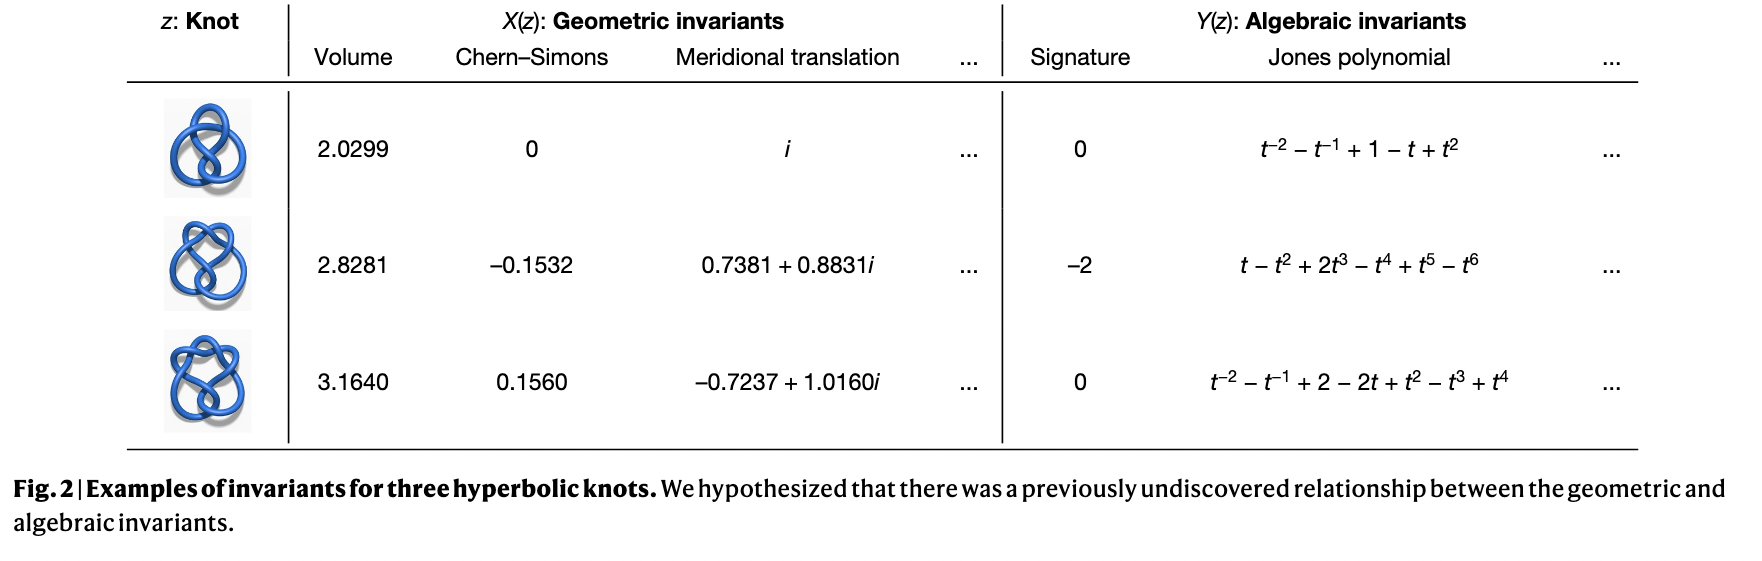

### Storyline of the Knot Theory Case

Having surveyed a range of geometric and algebraic invariants, we now turn to the
workflow followed in the *Nature* study.

- **Intuition.** Mathematicians had long suspected hidden relationships between different families of invariants, but no clear link was known.  
- **Data.** They assembled large tables of invariants for many knots, combining algebraic ones with geometric ones (e.g. signature $\sigma(K)$).  
- **AI Hint.** Simple predictive models were trained to estimate one invariant from the others, revealing which invariants carried the strongest signal.  
- **Observation.** A striking correlation emerged between other invariants and the knot signature $\sigma(K)$.  
- **Human Step.** Guided by this pattern, mathematicians formulated a precise conjecture and eventually proved it using knot-theoretic methods.

In this notebook, we reproduce this **discovery pipeline on a smaller scale**: not to re-prove the theorem, but to see how AI can highlight meaningful relationships and guide mathematical insight.

##  Invariant Selection

Before AI can help, we need a **rich dataset** of knot invariants.

**Mathematicians’ choice.**  
They selected 19 promising **hyperbolic invariants** as features.  
These capture geometric and symmetry properties of the knot complement.  
Descriptions of each invariant can be found at [KnotInfo](https://knotinfo.math.indiana.edu/).

At this stage, **no AI is involved**. The choice of invariants reflects mathematical experience and intuition.  
Without interesting features, any subsequent modeling would be aimless.

In [ ]:
display_name_from_short_name = {
    'chern_simons': 'Chern-Simons',
    'cusp_volume': 'Cusp volume',
    'hyperbolic_adjoint_torsion_degree': 'Adjoint Torsion Degree',
    'hyperbolic_torsion_degree': 'Torsion Degree',
    'injectivity_radius': 'Injectivity radius',
    'longitudinal_translation': 'Longitudinal translation',
    'meridinal_translation_imag': 'Re(Meridional translation)',
    'meridinal_translation_real': 'Im(Meridional translation)',
    'short_geodesic_imag_part': 'Im(Short geodesic)',
    'short_geodesic_real_part': 'Re(Short geodesic)',
    'Symmetry_0': 'Symmetry: $0$',
    'Symmetry_D3': 'Symmetry: $D_3$',
    'Symmetry_D4': 'Symmetry: $D_4$',
    'Symmetry_D6': 'Symmetry: $D_6$',
    'Symmetry_D8': 'Symmetry: $D_8$',
    'Symmetry_Z/2 + Z/2': 'Symmetry: $\\frac{Z}{2} + \\frac{Z}{2}$',
    'volume': 'Volume',
}
column_names = list(display_name_from_short_name)
target = 'signature'

## The Knot Signature

The **signature** $\sigma(K)$ is a classical integer-valued knot invariant, introduced by Trotter and Murasugi.  
Intuitively, it measures an "algebraic orientation balance" of the knot — a way of detecting asymmetry in how cycles on a Seifert surface interact.

---

**Geometric–algebraic construction.**

1. Choose an orientable surface $S$ whose boundary is $K$ (a **Seifert surface**).  
   The normal bundle $NS$ of $S$ consists of vectors orthogonal to the tangent space at each point of $S$.

2. For cycles $a, b \in H_1(S)$, consider their lifts $a^+$ and $b^-$ slightly pushed off $S$ in the positive and negative normal directions.  
   The **linking number** $\operatorname{lk}(a^+, b^-)$ counts how many times these shifted cycles wind around one another.

3. This defines a bilinear form
   $$
   \varphi : H_1(S) \times H_1(S) \;\to\; \mathbb{Z}, \qquad
   \varphi(a,b) = \operatorname{lk}(a^+, b^-),
   $$
   called the **Seifert form** of $S$.

4. Choosing a basis $b_1, \dots, b_{2g}$ for $H_1(S)$ (where $g$ is the genus of $S$), the Seifert form is represented by a $2g \times 2g$ **Seifert matrix** $V$, with entries
   $$
   V_{ij} = \varphi(b_i, b_j).
   $$

5. The **signature** of the knot $K$ is defined as the signature of the symmetrized matrix
   $$
   A = V + V^\top,
   \qquad
   \sigma(K) = \operatorname{sgn}(A) = n_+ - n_-,
   $$
   where $n_+$ (resp. $n_-$) is the number of positive (resp. negative) eigenvalues of $A$.

---

**Key fact.**  
Since $n_+ + n_- = 2g$, it follows that
$$
\sigma(K) = n_+ - n_- = 2n_+ - 2g,
$$
so $\sigma(K)$ is always an **even integer**.

---

**Examples.**
- $\sigma(\text{unknot}) = 0$  
- $\sigma(\text{trefoil}) = \pm 2$ (depending on orientation)  
- $\sigma(\text{figure-eight}) = 0$

Mathematicians generated a dataset of approximately 2 million knots.  Due to computational limitations (invariant calculation could be time-consuming or fail), the final dataset comprised roughly 240,000 knots, each described by 17 hyperbolic invariants.

We will now download the data.

In [ ]:
_, input_filename = tempfile.mkstemp()
!gsutil cp "gs://maths_conjectures/knot_theory/knot_theory_invariants.csv" {input_filename}

full_df = pd.read_csv(input_filename)

Copying gs://maths_conjectures/knot_theory/knot_theory_invariants.csv...
/ [1 files][ 48.6 MiB/ 48.6 MiB]                                                
Operation completed over 1 objects/48.6 MiB.                                     


In [ ]:
full_df.describe()

,Unnamed: 0,hyperbolic_adjoint_torsion_degree,hyperbolic_torsion_degree,short_geodesic_real_part,short_geodesic_imag_part,injectivity_radius,chern_simons,cusp_volume,longitudinal_translation,meridinal_translation_imag,meridinal_translation_real,volume,Symmetry_0,Symmetry_D3,Symmetry_D4,Symmetry_D6,Symmetry_D8,Symmetry_Z/2 + Z/2,signature
count,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000,243746.000000
mean,126089.867403,4.694009,9.740213,0.957646,-0.029384,0.460853,-0.000027,13.812728,13.605623,1.075130,0.001433,13.598932,0.310073,0.000455,0.019906,0.001350,0.000053,0.275237,0.007377
std,72810.451937,6.867480,4.085802,0.349347,2.554737,0.151301,0.145773,4.253328,4.781169,0.285420,0.826633,4.870631,0.462524,0.021335,0.139677,0.036714,0.007303,0.446635,3.046598
min,0.000000,0.000000,0.000000,0.048011,-3.141576,0.024005,-0.249994,3.464102,2.962636,0.125610,-2.109556,2.029883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.000000
25%,63027.250000,0.000000,6.000000,0.717237,-2.617054,0.358618,-0.126209,10.996365,10.266059,0.899696,-0.718682,10.183266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000
50%,126095.500000,0.000000,10.000000,0.949265,-0.833061,0.474632,0.000000,13.748669,13.029922,1.134978,0.000000,12.996234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,189126.750000,9.000000,14.000000,1.247849,2.595936,0.596426,0.125769,16.449269,16.351883,1.272927,0.719870,16.600399,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
max,252191.000000,39.000000,30.000000,2.295841,3.141514,0.864239,0.249992,34.009731,53.393242,2.189435,2.326625,37.659210,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000


## Load and preprocess data


Split the data into a training, a validation and a holdout test set

Train len: 182809 Val len: 30468 Test len: 30469


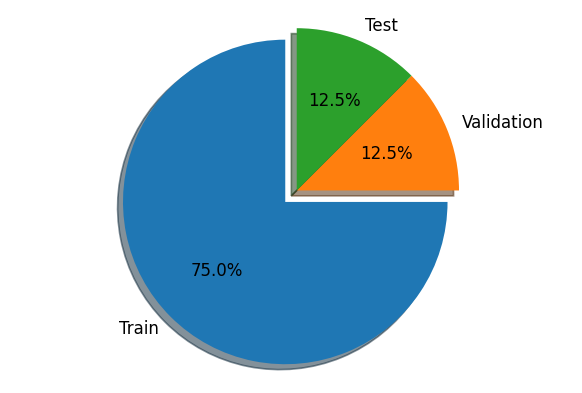

In [ ]:
random_seed = 2 # @param {type: "integer"}
random_state = np.random.RandomState(random_seed)
train_df, validation_and_test_df = train_test_split(
    full_df, random_state=random_state)
validation_df, test_df = train_test_split(
    validation_and_test_df, test_size=.5, random_state=random_state)

print(f'Train len: {len(train_df)}',
      f'Val len: {len(validation_df)}',
      f'Test len: {len(test_df)}')


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(validation_df), len(test_df)]
explode = (0.1, 0, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Find the minimal and maximal value of target function

In [ ]:
# Find bounds for the signature in the training dataset.
max_signature = train_df[target].max()
min_signature = train_df[target].min()
print(f'Max signature: {max_signature}')
print(f'Min signature: {min_signature}')

Max signature: 14
Min signature: -12


### Normalize data

In [ ]:
def normalize_features(df, cols, add_target=True):
  features = df[cols]
  sigma = features.std()
  if any(sigma == 0):
    print(sigma)
    raise RuntimeError(
        "A poor data stratification has led to no variation in one of the data "
        "splits for at least one feature (ie std=0). Restratify and try again.")
  mu = features.mean()
  normed_df = (features - mu) / sigma
  if add_target:
    normed_df[target] = df[target]
  return normed_df

def get_batch(df, cols, size=None):
  batch_df = df if size is None else df.sample(size)
  X = batch_df[cols].to_numpy()
  y = batch_df[target].to_numpy()
  return X, y

normed_train_df = normalize_features(train_df, column_names)
normed_validation_df = normalize_features(validation_df, column_names)
normed_test_df = normalize_features(test_df, column_names)
print(normed_train_df.shape, normed_validation_df.shape, normed_test_df.shape)

(182809, 18) (30468, 18) (30469, 18)


Check that the data is normalized:

In [ ]:
normed_train_df.describe()

,chern_simons,cusp_volume,hyperbolic_adjoint_torsion_degree,hyperbolic_torsion_degree,injectivity_radius,longitudinal_translation,meridinal_translation_imag,meridinal_translation_real,short_geodesic_imag_part,short_geodesic_real_part,Symmetry_0,Symmetry_D3,Symmetry_D4,Symmetry_D6,Symmetry_D8,Symmetry_Z/2 + Z/2,volume,signature
count,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,1.828090e+05,182809.000000
mean,-3.296010e-17,-2.288161e-16,6.358811e-17,-2.209454e-16,2.439455e-17,-1.716801e-16,-3.078252e-16,-1.298193e-17,-1.741288e-17,1.030392e-16,-5.227751e-18,-6.024546e-18,5.425978e-17,1.465325e-17,-1.224343e-18,-2.005591e-17,-1.171871e-16,0.002188
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.044834
min,-1.713160e+00,-2.431795e+00,-6.836555e-01,-2.385096e+00,-2.887799e+00,-2.226789e+00,-3.326689e+00,-2.550834e+00,-1.216302e+00,-2.604509e+00,-6.704172e-01,-2.105420e-02,-1.413507e-01,-3.730086e-02,-7.396255e-03,-6.165774e-01,-2.375007e+00,-12.000000
25%,-8.686016e-01,-6.629551e-01,-6.836555e-01,-9.165836e-01,-6.751558e-01,-6.984365e-01,-6.137624e-01,-8.701891e-01,-1.010990e+00,-6.875486e-01,-6.704172e-01,-2.105420e-02,-1.413507e-01,-3.730086e-02,-7.396255e-03,-6.165774e-01,-7.011479e-01,-2.000000
50%,1.491773e-03,-1.540330e-02,-6.836555e-01,6.242478e-02,9.199272e-02,-1.200560e-01,2.074567e-01,-4.050838e-05,-3.534882e-01,-2.291661e-02,-6.704172e-01,-2.105420e-02,-1.413507e-01,-3.730086e-02,-7.396255e-03,-6.165774e-01,-1.236561e-01,0.000000
75%,8.607747e-01,6.198412e-01,6.272469e-01,1.041433e+00,8.952673e-01,5.762042e-01,6.934377e-01,8.697971e-01,1.028812e+00,8.289475e-01,1.491600e+00,-2.105420e-02,-1.413507e-01,-3.730086e-02,-7.396255e-03,1.621848e+00,6.147528e-01,2.000000
max,1.716128e+00,4.745990e+00,4.996922e+00,4.957467e+00,2.668284e+00,8.326586e+00,3.262354e+00,2.626091e+00,1.243070e+00,3.519368e+00,1.491600e+00,4.749620e+01,7.074562e+00,2.680889e+01,1.352028e+02,1.621848e+00,4.939560e+00,14.000000


## Train Neural Network


### The neural network model

- **Architecture.**  
  The network is a standard **multilayer perceptron (MLP)**:
  - Input layer of size 17 (the number of invariants/features).  
  - 3 hidden layers, each with 300 neurons and a sigmoid activation.  
  - Output layer with $\tfrac{\text{max_signature} - \text{min_signature}}{2}$ neurons, corresponding to the number of possible signature classes (recall: signatures are always even integers).  

- **Output.**  
  The final layer produces a vector of logits $q$.  
  Applying the **softmax** function turns this into a probability distribution:
  $$
  \widehat{p}(y=i \mid x) \;=\; \frac{e^{q_i}}{\sum_j e^{q_j}}.
  $$

- **Interpretation.**  
  The $i$-th entry of $\operatorname{softmax}(q)$ is the predicted probability that the knot’s signature equals
  $$
  2i + \text{min\_signature}.
  $$
  In other words, the model directly classifies the knot into one of the allowed even signature values.

- **Why this architecture?**  
  - It is intentionally **simple**.  
  - With only 17 input features, complex architectures are unnecessary.  
  - The goal here is **not** to achieve state-of-the-art accuracy, but to let the model highlight which invariants carry predictive signal (to be analyzed later via saliency).

In [ ]:
class Net(nn.Module):
    def __init__(self, max_signature, min_signature, input_size=17):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 300),
            nn.Sigmoid(),
            nn.Linear(300, 300),
            nn.Sigmoid(),
            nn.Linear(300, 300),
            nn.Sigmoid(),
            nn.Linear(300, int((max_signature - min_signature) / 2))
        )

    def forward(self, inp):
        return self.layers(inp)

    def predict(self, data_X):
        predictions = self.layers(data_X)
        # Get the predicted class indices
        predicted_classes = torch.argmax(predictions, dim=1)
        # Adjust the predictions based on min_signature
        adjusted_predictions = (predicted_classes * 2 + min_signature)
        return adjusted_predictions

We take the **cross-entropy** between this predicted distribution and the true distribution  
(i.e. a one-hot vector: $1$ at the true signature value, $0$ everywhere else) as the loss function.

**What is cross-entropy?**  
Suppose the model outputs a probability distribution $q$ over possible classes, and the true distribution is $p$.  
- In our case, $p$ is a one-hot vector: $p_i = 1$ if $i$ is the true class, $0$ otherwise.  
- The cross-entropy is defined as
  $$
  H(p,q) \;=\; - \sum_i p_i \log q_i.
  $$
- Since $p$ is one-hot, this reduces to
  $$
  H(p,q) = - \log q_{y},
  $$
  where $y$ is the index of the true class.

**Interpretation.**  
- Cross-entropy measures how well the model assigns probability to the correct class.  
- If the model is confident and correct ($q_y \approx 1$), the loss is near $0$.  
- If the model assigns low probability to the true class ($q_y \ll 1$), the loss is large.  
- Minimizing cross-entropy therefore pushes the model to assign high probability to the true signature.

In [ ]:
def softmax_cross_entropy(logits, labels, min_signature=min_signature):
    # Ensure all transformed label values are within the valid range
    transformed_labels = (labels - min_signature) // 2
    # Clamp transformed labels to be within [0, num_classes - 1]
    transformed_labels = torch.clamp(transformed_labels, 0, logits.shape[-1] - 1)
    one_hot = torch.nn.functional.one_hot(transformed_labels, num_classes=logits.shape[-1])
    return -torch.sum(torch.nn.functional.log_softmax(logits, dim=-1) * one_hot, dim=-1)

def loss_f(logits, labels):
  return torch.mean(softmax_cross_entropy(logits, labels))

### Model + Loss + Optmizer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_training_steps = 10_000
validation_interval = 100

# Initialize model
model = Net(max_signature=max_signature, min_signature=min_signature)
criterion = loss_f
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Training loop

We now train the neural network using **mini-batch gradient descent**:  
1. Repeatedly sample a batch from the training set.  
2. Compute predictions and the loss.  
3. Backpropagate gradients and update weights.  
4. Periodically evaluate on the validation set to track progress and apply early stopping if validation loss worsens.  
5. Finally, measure accuracy on the held-out test set.

In [ ]:
def training_loop(model, criterion, optimizer, num_training_steps,
                  validation_interval, normed_train_df, normed_validation_df,
                  normed_test_df, column_names, batch_size, silent=False):
    best_validation_loss = np.inf
    train_losses = []
    val_losses = []
    for i in range(num_training_steps):
        train_X, train_y = get_batch(normed_train_df, column_names, batch_size)
        train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
        train_y_tensor = torch.tensor(train_y, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(train_X_tensor)
        loss = criterion(outputs, train_y_tensor)
        loss.backward()
        optimizer.step()

        if i % validation_interval == 0:
            validation_X, validation_y = get_batch(normed_validation_df, column_names)
            validation_X_tensor = torch.tensor(validation_X, dtype=torch.float32)
            validation_y_tensor = torch.tensor(validation_y, dtype=torch.long)

            with torch.no_grad(): # Disable gradient calculations for validation
                train_loss = criterion(model(train_X_tensor), train_y_tensor)
                validation_loss = criterion(model(validation_X_tensor), validation_y_tensor)
                train_losses.append(train_loss.item())
                val_losses.append(validation_loss.item())
            if not silent:
                print(f"Step count: {i}")
                print(f"Train loss: {train_loss.item()}")
                print(f"Validation loss: {validation_loss.item()}")

            if validation_loss > best_validation_loss:
                print("Validation loss increased. Stopping!")
                break
            else:
                best_validation_loss = validation_loss


    # Test the model
    test_X, test_y = get_batch(normed_test_df, column_names)
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32)

    with torch.no_grad():
        predictions = model.predict(test_X_tensor)
        test_accuracy = np.mean((predictions.numpy() - test_y) == 0)
    if not silent:
      print("Test Accuracy: ", test_accuracy)
    return model, train_losses, val_losses, test_accuracy

# Train the model
trained_model, train_losses, val_losses, test_accuracy = training_loop(model, criterion, optimizer, num_training_steps,
                      validation_interval, normed_train_df,
                      normed_validation_df, normed_test_df, column_names, batch_size)


Step count: 0
Train loss: 2.437323570251465
Validation loss: 2.4359607696533203
Step count: 100
Train loss: 1.6708598136901855
Validation loss: 1.5207717418670654
Step count: 200
Train loss: 0.7144789695739746
Validation loss: 0.5726476311683655
Step count: 300
Train loss: 0.5406249165534973
Validation loss: 0.49326708912849426
Step count: 400
Train loss: 0.38791853189468384
Validation loss: 0.48692017793655396
Step count: 500
Train loss: 0.5120790600776672
Validation loss: 0.4618111848831177
Step count: 600
Train loss: 0.4376458525657654
Validation loss: 0.4490780234336853
Step count: 700
Train loss: 0.47825688123703003
Validation loss: 0.41111281514167786
Step count: 800
Train loss: 0.31450557708740234
Validation loss: 0.4167724847793579
Validation loss increased. Stopping!
Test Accuracy:  0.8244773376218452


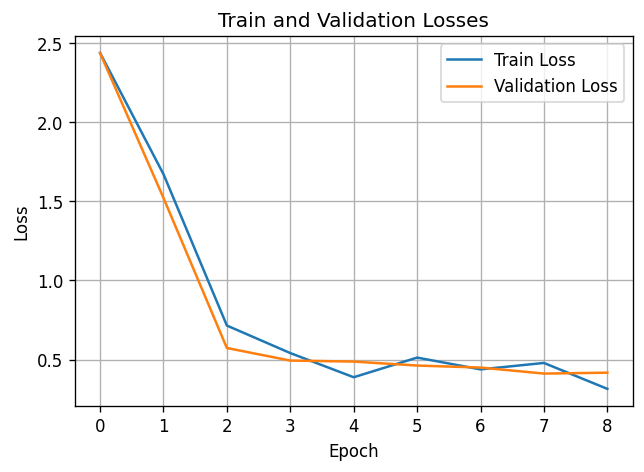

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.show()

The trained neural network predicted the signature from the hyperbolic invariants with over 75% accuracy, suggesting a previously unknown relationship.

## Feature selection via saliency (gradient-based)

**Goal.** Identify which hyperbolic invariants most influence the model’s prediction of the signature.

**Method (saliency).** For a trained model $f_\theta(x)$ and loss $\mathcal{L}(f_\theta(x), y)$, define the saliency of feature $i$ on a dataset $\mathcal{D}$ as
$$
S_i \;=\; \mathbb{E}_{(x,y)\in\mathcal{D}}\!\left[\,\left|\frac{\partial \mathcal{L}}{\partial x_i}\right|\,\right].
$$
Larger $S_i$ means the loss changes more when we perturb feature $x_i$ (after normalization), i.e., the feature is more influential for the current model.

**Notes.**
- We compute gradients w.r.t. the **normalized** inputs to make scales comparable.
- Saliency reflects the trained network and objective (not universal causality).
- For tabular data, you might compare with **Permutation Importance**, **Integrated Gradients**, or **SHAP**; we keep saliency here for clarity and speed.

Top-10 features by saliency:
Im(Meridional translation)               1.052297
Longitudinal translation                 0.708359
Re(Meridional translation)               0.583856
Injectivity radius                       0.091715
Symmetry: $D_8$                          0.059709
Cusp volume                              0.059302
Im(Short geodesic)                       0.059127
Symmetry: $D_6$                          0.035695
Symmetry: $\frac{Z}{2} + \frac{Z}{2}$    0.031285
Torsion Degree                           0.023532
dtype: float32


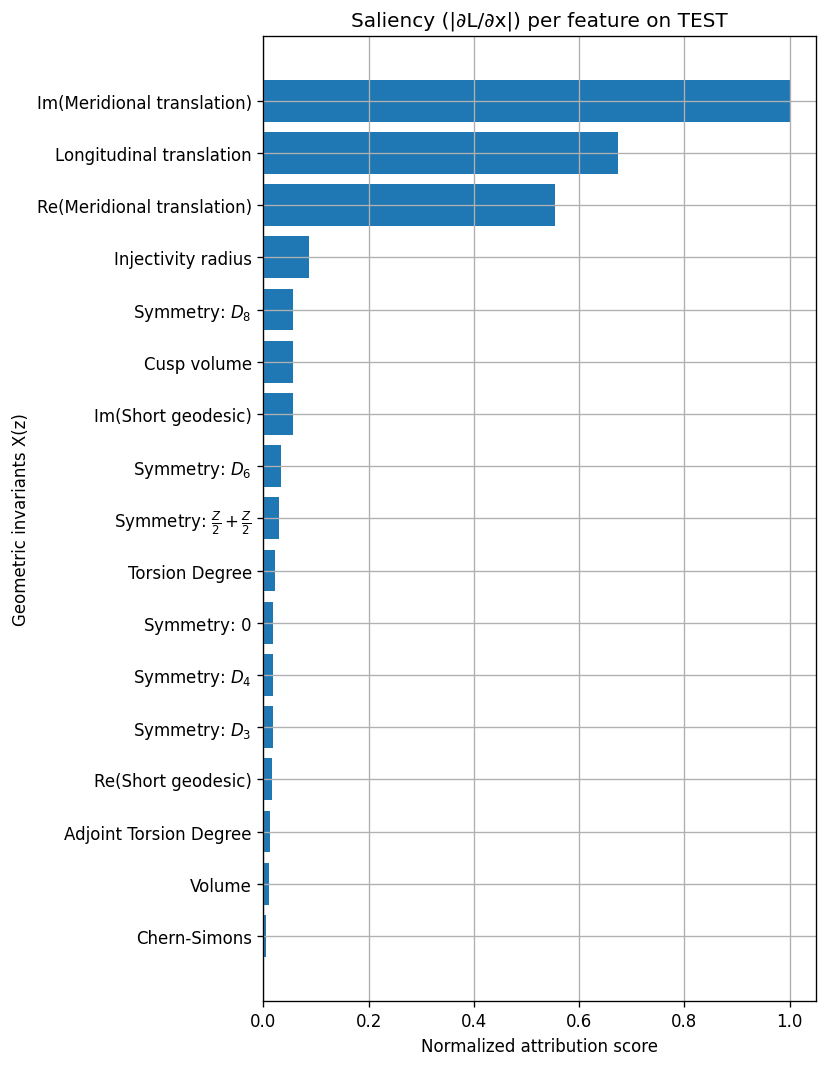

In [ ]:

# Resolve common names from previous cells (be robust to naming differences)
TARGET = target if "target" in globals() else "signature"

if "FEATURES" in globals():
    feature_cols = feature_cols
elif "column_names" in globals():
    feature_cols = column_names
else:
    feature_cols = [c for c in normed_test_df.columns if c != TARGET]

# Use the trained model reference (either `trained_model` from your loop, or `model` from the refactor)
m = trained_model if "trained_model" in globals() else model
m.eval()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m.to(DEVICE)

# Class mapping from signatures to indices (must match training)
sigma_min = int(train_df[TARGET].min())
sigma_max = int(train_df[TARGET].max())
num_classes = int((sigma_max - sigma_min) // 2 + 1)

def sig_to_class(sig_array: np.ndarray) -> np.ndarray:
    idx = ((sig_array - sigma_min) // 2).astype(int)
    return np.clip(idx, 0, num_classes - 1)

# Prepare full TEST tensors
X_test = normed_test_df[feature_cols].to_numpy(dtype=np.float32)
y_test = sig_to_class(normed_test_df[TARGET].to_numpy())

N, D = X_test.shape

batch_size = 1024
saliency_sum = torch.zeros(D, device=DEVICE)

# We compute per-sample CE and sum losses in a batch; then average |grad| over all samples at the end.
for start in range(0, N, batch_size):
    end = min(N, start + batch_size)
    xb = torch.tensor(X_test[start:end], device=DEVICE, requires_grad=True)
    yb = torch.tensor(y_test[start:end], device=DEVICE, dtype=torch.long)

    m.zero_grad(set_to_none=True)
    logits = m(xb)
    # per-sample CE; sum to make gradient additive over samples
    loss = torch.nn.functional.cross_entropy(logits, yb, reduction="sum")
    loss.backward()

    # accumulate absolute gradients over samples in this batch
    saliency_sum += xb.grad.detach().abs().sum(dim=0)

# Average over all samples
saliency = (saliency_sum / N).detach().cpu().numpy()

# Build a labeled Series; prefer human-readable names if available
if "display_name_from_short_name" in globals():
    display_names = [display_name_from_short_name.get(c, c) for c in feature_cols]
else:
    display_names = feature_cols

saliency_s = pd.Series(saliency, index=display_names).sort_values(ascending=False)

# Quick text summary
print("Top-10 features by saliency:")
print(saliency_s.head(10))

vals = saliency_s.values
norm_vals = vals / (vals.max() if vals.max() > 0 else 1.0)

plt.figure(figsize=(7, 9))
plt.barh(saliency_s.index[::-1], norm_vals[::-1])
plt.xlabel("Normalized attribution score")
plt.ylabel("Geometric invariants X(z)")
plt.title("Saliency (|∂L/∂x|) per feature on TEST")
plt.tight_layout()
plt.show()

**What you should observe (qualitatively):**  
The following three invariants often dominate the saliency ranking:
1. **Longitudinal translation**  
2. **Re(Meridional translation)**  
3. **Im(Meridional translation)**

This mirrors the paper’s observation that specific hyperbolic translation data are strongly predictive of the signature.  
In the next step, we’ll use this to guide a **candidate conjecture**.

## Feature analysis — the **natural slope**

Guided by the saliency results, the mathematicians introduced the **natural slope** of a knot:
$$
\operatorname{slope}(K) \;=\; \operatorname{Re}\!\left(\frac{\lambda}{\mu}\right),
$$
where $\lambda$ and $\mu$ are, respectively, the (complex) **longitudinal** and **meridional** translations arising from the hyperbolic structure of the knot complement, and $\operatorname{Re}$ denotes the real part.

**Geometric interpretation (informal).**  
Realize the meridian as a geodesic $\gamma$ on the Euclidean torus $\mathbb{T}^2$. Fire a geodesic $\gamma^\perp$ orthogonally from $\gamma$; when it first returns to intersect $\gamma$ again, it will have traversed a longitude minus some multiple of the meridian. That multiple is the natural slope. It need not be an integer because the endpoint of $\gamma^\perp$ need not coincide with its starting point.

**Empirical observation.**  
On the dataset, the slope strongly correlates with the signature $\sigma(K)$ and is approximately **twice** the signature (up to a small correction). We test this by using the slope as a **single** predictive feature for $\sigma(K)$ and measuring accuracy after quantizing to even integers.

In [ ]:
LON = "longitudinal_translation"
MER_RE = "meridinal_translation_real"
MER_IM = "meridinal_translation_imag"
TARGET = target if "target" in globals() else "signature"

# Train split defines the valid signature range/classes
sigma_min = int(train_df[TARGET].min())
sigma_max = int(train_df[TARGET].max())
assert sigma_min % 2 == 0 and sigma_max % 2 == 0

def predict_signature_from_slope(frame: pd.DataFrame) -> np.ndarray:
    """Return a *real-valued* (non-quantized) signature proxy from slope."""
    mu = frame[MER_RE].to_numpy() + 1j * frame[MER_IM].to_numpy()
    lam = frame[LON].to_numpy().astype(np.complex128)
    # Guard against division by (near-)zero meridian translation
    eps = 1e-12
    safe = np.where(np.abs(mu) > eps, lam / mu, 0.0)
    slope = np.real(safe)
    # Paper’s heuristic: slope ≈ 2 * signature  ==> signature ≈ slope / 2
    return slope / 2.0

def quantize_to_even(sig_real: np.ndarray, smin: int, smax: int) -> np.ndarray:
    """Quantize real-valued signature to the nearest even integer in [smin, smax]."""
    q = 2 * np.round(sig_real / 2.0)
    q = np.clip(q, smin, smax)
    return q.astype(int)

# Predictions on the held-out TEST split
pred_real = predict_signature_from_slope(test_df)
pred_int = quantize_to_even(pred_real, sigma_min, sigma_max)

y_true = test_df[TARGET].to_numpy()
acc = (pred_int == y_true).mean()
mae = np.mean(np.abs(pred_int - y_true))

print(f"Test accuracy (slope-only, quantized): {acc:.3f}")
print(f"Test MAE (even-signature units): {mae:.2f}")

Test accuracy (slope-only, quantized): 0.738
Test MAE (even-signature units): 0.52


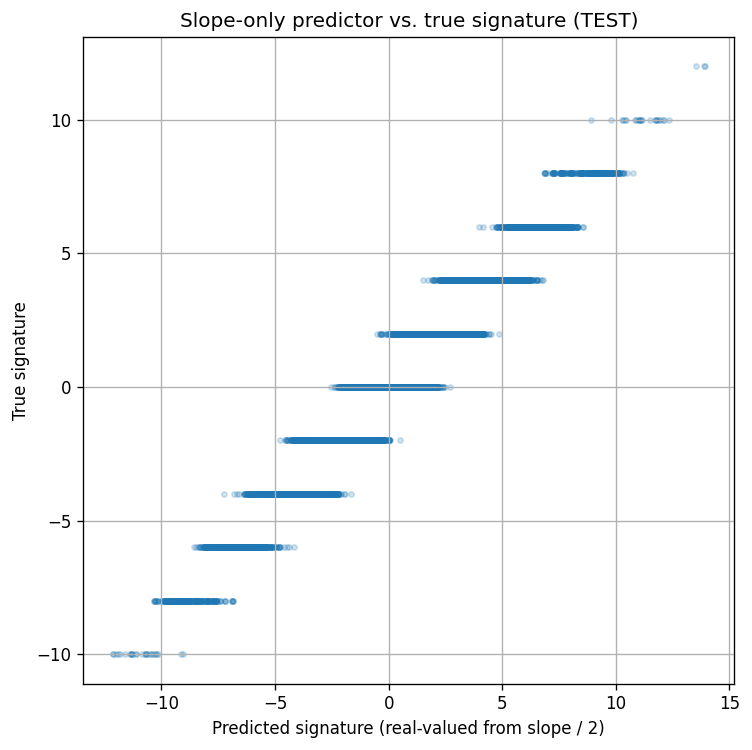

In [ ]:
# Scatter: real-valued slope-based prediction vs. true signature (TEST)
plt.figure(figsize=(7, 7))
plt.scatter(pred_real, y_true, alpha=0.2, s=10)
plt.xlabel("Predicted signature (real-valued from slope / 2)")
plt.ylabel("True signature")
plt.title("Slope-only predictor vs. true signature (TEST)")
plt.grid(True)
plt.show()

In [ ]:
# Simple confusion-style view around the diagonal (optional)
# Show a small random sample of (predicted, true)
idx = np.random.default_rng(0).choice(len(y_true), size=min(20, len(y_true)), replace=False)
for p, t in zip(pred_int[idx], y_true[idx]):
    print(f"pred={int(p):>3} | true={int(t):>3}")

pred=  4 | true=  4
pred=  0 | true=  0
pred=  2 | true=  2
pred=  6 | true=  4
pred=  0 | true=  0
pred= -2 | true= -2
pred=  2 | true=  2
pred=  2 | true=  2
pred= -4 | true= -4
pred=  2 | true=  2
pred=  0 | true=  0
pred=  0 | true=  0
pred=  4 | true=  2
pred=  0 | true=  0
pred= -6 | true= -4
pred=  0 | true=  0
pred= -2 | true= -2
pred=  0 | true=  0
pred=  0 | true=  0
pred=  2 | true=  2


**What to expect.**  
- Using the slope alone typically yields a **high** accuracy (reported around $70$–$80\%$ on similar splits), indicating that most of the predictive power of the hyperbolic features concentrates in the longitudinal/meridional translation data.  
- Discrepancies can often be attributed to quantization at even integers and small systematic offsets (the “correction term”).

**Takeaway.**  
A single, geometrically meaningful quantity — the **natural slope** — explains most of the learned model’s behavior. This is precisely the kind of **AI $\rightarrow$ human insight** handoff we want: the network highlights which features matter; humans distill them into a compact invariant with a clear geometric meaning.

##Hypothesis formulation.

The final stage of the workflow is translating **patterns** into **precise conjectures** — and eventually proofs.

---

**Initial conjecture (data-inspired).**

From the strong empirical correlation between the **slope** and the signature, mathematicians proposed:

> **Conjecture.**  
> There exist constants $c_1, c_2$ such that, for every hyperbolic knot $K$,  
> $$
> \big|\, 2\sigma(K) - \operatorname{slope}(K) \,\big| < c_1 \operatorname{vol}(K) + c_2.
> $$

Here:
- $\sigma(K)$ = signature,  
- $\operatorname{slope}(K)$ = natural slope,  
- $\operatorname{vol}(K)$ = hyperbolic volume of the knot complement.

---

**Testing & refinement.**

- To test robustness, they generated a dataset of ~36,000 knots from a particular subfamily.  
- In this restricted class, **counterexamples** to the conjecture appeared.  
- Analysis of the residuals suggested that other hyperbolic invariants — especially the **injectivity radius** — must play a role.

---

**Refined theorem (proved).**

Eventually, they established a provable inequality:

> **Theorem (Davies et al., 2021).**  
> There exists a constant $c$ such that, for any hyperbolic knot $K$,  
> $$
> \big|\,2\sigma(K) - \operatorname{slope}(K) \,\big| \;\leq\; c \,\frac{ \operatorname{vol}(K)}{ \operatorname{inj}(K)^3 }.
> $$

where $\operatorname{inj}(K)$ is the injectivity radius of $K$.

---

**Discussion.**

- This is a textbook example of **AI $\rightarrow$ conjecture $\rightarrow$ proof**.  
- The neural network did not directly “prove” anything.  
- Instead, it highlighted the **salient invariants** (translations), guiding humans toward the **natural slope**.  
- Careful empirical stress-testing refined the conjecture and revealed missing invariants (volume, injectivity radius).  
- Finally, traditional mathematics delivered a **theorem** with proof.


## Conclusion

**What we did.**  
- In this knot theory case study, **deep learning** entered only at **Step 3 (training a neural net)**.  
- The crucial feature selection (Step 4) could plausibly have been achieved with simpler statistical tools, given the relatively small set of invariants.  
- Constructing the dataset itself was nontrivial: it required **specialized, computationally intensive software** to compute hyperbolic invariants.  
- The **relationship uncovered** had a surprisingly simple form,
  $$
  \sigma \;\approx\; \frac{\lambda a}{2(a^2+b^2)},
  $$
  yielding about **78% predictive accuracy**.  
  But note: the network only established **predictability**, not the **formula or proof**.

---

**What this tells us about DL in mathematics.**

Deep learning does not produce proofs. Instead, it gives us:

> After examining millions of examples, there is a pattern that works $X\%$ of the time, and it depends primarily on features $A,B,C$.

This is valuable: it points mathematicians toward the *right features* and *candidate relationships*.

---

<font color='blue'>**Question for discussion:**</font>  
How useful can such results be in mathematics?  
- As a **heuristic compass**, guiding human intuition and conjecture?  
- As a **replacement for human proof** (unlikely)?  
- As a way to **explore enormous combinatorial spaces** and surface hidden structures humans would not otherwise notice?

---

**Takeaway.**  
The power of AI here is not in replacing human reasoning, but in **augmenting it**: highlighting patterns, prioritizing directions, and enabling humans to craft and prove theorems. The collaboration succeeds when both sides — AI’s breadth of search and human depth of reasoning — complement each other.